# Maana Q: Generalized Algebraic Theories (GATs)

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats.png)

## Installation

In [164]:
using Pkg
Pkg.activate(mktempdir())

Pkg.add("Catlab")
using Catlab.Core
using Catlab.Theories
using Catlab.Syntax
using Catlab.Present	
using Catlab.Programs	
using Catlab.WiringDiagrams
using Catlab.Graphics

Pkg.add("TikzPictures")
using TikzPictures

Pkg.add("TikzGraphs")
using TikzGraphs

Pkg.add("LightGraphs")
using LightGraphs

Pkg.add("Convex") 
import Convex

Pkg.add("SCS")
import SCS

Pkg.add("JSON")
import JSON


 Activating new environment at `/var/folders/sg/1_7xybtx76j654qjl99l92ph0000gq/T/jl_nbmkyX/Project.toml`
  Resolving package versions...
Updating `/private/var/folders/sg/1_7xybtx76j654qjl99l92ph0000gq/T/jl_nbmkyX/Project.toml`
  [134e5e36] + Catlab v0.9.1
Updating `/private/var/folders/sg/1_7xybtx76j654qjl99l92ph0000gq/T/jl_nbmkyX/Manifest.toml`
  [79e6a3ab] + Adapt v2.3.0
  [ec485272] + ArnoldiMethod v0.0.4
  [56f22d72] + Artifacts v1.3.0
  [15f4f7f2] + AutoHashEquals v0.2.0
  [a603d957] + CanonicalTraits v0.2.3
  [134e5e36] + Catlab v0.9.1
  [944b1d66] + CodecZlib v0.7.0
  [3da002f7] + ColorTypes v0.10.9
  [5ae59095] + Colors v0.12.4
  [34da2185] + Compat v3.20.0
  [a81c6b42] + Compose v0.9.1
  [a8cc5b0e] + Crayons v4.0.4
  [9a962f9c] + DataAPI v1.3.0
  [864edb3b] + DataStructures v0.18.7
  [e2d170a0] + DataValueInterfaces v1.0.0
  [53c48c17] + FixedPointNumbers v0.8.4
  [59287772] + Formatting v0.4.1
  [069b7b12] + FunctionWrappers v1.1.1
  [6b9d7cbe] + GeneralizedGenerated v0.2.8


In [64]:
function show_diagram(d::WiringDiagram)
    to_graphviz(d, orientation=LeftToRight, labels=true)
end

show_diagram (generic function with 1 method)

## Applied Category Theory using GATs

### Two views on category theory and software [^Patterson1]

1. Designing with categories: CT informing the design, architecture, and implementation of computer programs, in any domain.

**Slogan**: *Design patterns, but better*

2. Computing on categories: data structures and algorithms for computing with objects and morphisms in categories.

**Slogan**: *Computer algebra of categories* or *computational category theory*

**These are orthogonal [and can be layered].**

!!! tip
	This notebook is about how to use Q for computational category theory (mostly).

[^Patterson1]: [Evan Patterson: Realizing Applied Category Theory in Julia](https://www.youtube.com/watch?v=7dmrDYQh4rc)

### Representing morphisms in monoidal categories

Transforming between different **computational representations** of morphisms in symmetric monoidal categories.

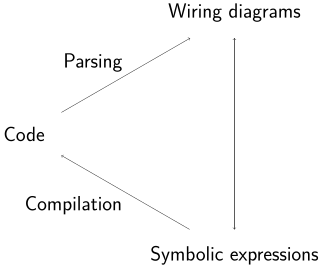

In [126]:
g = DiGraph(3)
add_edge!(g, 1, 2)
add_edge!(g, 2, 1)
add_edge!(g, 2, 3)
add_edge!(g, 3, 1)
TikzGraphs.plot(g, node_style="", options="scale=2, font=\\huge\\sf", TikzGraphs.Layouts.SpringElectrical(charge=25,dist=35), ["Wiring diagrams", "Symbolic expressions", "Code"], edge_labels=Dict((2,3)=>"Compilation", (3,1)=>"Parsing"))

## Theories and Signatures

An algebraic structure has the following data:

- **Theory**
  - **Signature**
    - **Type Constructors**: what "sort" of things is it about
    - **Term Constructors**: what "actions" can be taken on the sorts
  - **Axioms**: what "laws" must hold for the use of the operations on the sorts
  - **Aliases**: special symbols and the type or term it represents

This can be represented in Maana Q as:

![](https://github.com/maana-io/cat-ml/raw/master/images/maana-q-gats/theory-signature.png)

## Instances and Presentations

Instances are useful for casting generic data structures, such as matrices, abstract tensor systems, and wiring diagrams, in categorical language.

Presentations define small categories by generators and relations and are useful in applications like knowledge representation.

There are two methods of defining models of a GAT:
- Implementation: Julia `@instance`
- Presentation: Julia `@present`  

## Syntax

A syntax system for a GAT consists of Julia types (with top type `GATExpr`) for each `TypeConstructor` in the `Signature`, plus Julia functions for:
- **Generators**: creating new generator terms (e.g., objects or morphisms)
- **Accessors**: accessing type paramters (e.g., domains and codomains)
- **Term constructors**: applying term constructors (e.g., composition and monoidal products)

## Root Theories

### Category Theory

Our first theory using this language is that of a Category.

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats-category-theory.png)

#### Using `Catlab.jl`

In [259]:
module SandoxCat

using Catlab

@theory Category{Ob,Hom} begin

  # Aliases
  @op begin
    (→) := Hom
    (⋅) := compose
  end

  # Type Constructors
  Ob::TYPE
  Hom(dom::Ob,codom::Ob)::TYPE

  # Term Constructors
  id(A::Ob)::(A → A)
  compose(f::(A → B), g::(B → C))::(A → C) ⊣ (A::Ob, B::Ob, C::Ob)

  # Axioms
  ((f ⋅ g) ⋅ h == f ⋅ (g ⋅ h) ⊣ (A::Ob, B::Ob, C::Ob, D::Ob, f::(A → B), g::(B → C), h::(C → D)))
  f ⋅ id(B) == f ⊣ (A::Ob, B::Ob, f::(A → B))
  id(A) ⋅ f == f ⊣ (A::Ob, B::Ob, f::(A → B))

end

end

Main.SandoxCat

In [70]:

@syntax FreeCategory{ObExpr,HomExpr} Category begin
  compose(f::Hom, g::Hom) = associate(new(f,g; strict=true))
end

Main.FreeCategory

##### Extract the theory

In [168]:
cat_theory = theory(Main.SandoxCat.Category)


Catlab.GAT.Theory(Catlab.GAT.TypeConstructor[Catlab.GAT.TypeConstructor(:Ob, Symbol[], OrderedCollections.OrderedDict{Symbol,Union{Expr, Symbol}}(), nothing), Catlab.GAT.TypeConstructor(:Hom, [:dom, :codom], OrderedCollections.OrderedDict{Symbol,Union{Expr, Symbol}}(:dom => :Ob,:codom => :Ob), nothing)], Catlab.GAT.TermConstructor[Catlab.GAT.TermConstructor(:id, [:A], :(Hom(A, A)), OrderedCollections.OrderedDict{Symbol,Union{Expr, Symbol}}(:A => :Ob), nothing), Catlab.GAT.TermConstructor(:compose, [:f, :g], :(Hom(A, C)), OrderedCollections.OrderedDict{Symbol,Union{Expr, Symbol}}(:A => :Ob,:B => :Ob,:C => :Ob,:f => :(Hom(A, B)),:g => :(Hom(B, C))), nothing)], Catlab.GAT.AxiomConstructor[Catlab.GAT.AxiomConstructor(:(==), :(compose(compose(f, g), h)), :(compose(f, compose(g, h))), OrderedCollections.OrderedDict{Symbol,Union{Expr, Symbol}}(:A => :Ob,:B => :Ob,:C => :Ob,:D => :Ob,:f => :(Hom(A, B)),:g => :(Hom(B, C)),:h => :(Hom(C, D))), nothing), Catlab.GAT.AxiomConstructor(:(==), :(compo

##### Convert to JSON

In [176]:
cat_json = JSON.json(cat_theory)

"{\"types\":[{\"name\":\"Ob\",\"params\":[],\"context\":{},\"doc\":null},{\"name\":\"Hom\",\"params\":[\"dom\",\"codom\"],\"context\":{\"dom\":\"Ob\",\"codom\":\"Ob\"},\"doc\":null}],\"terms\":[{\"name\":\"id\",\"params\":[\"A\"],\"typ\":{\"head\":\"call\",\"args\":[\"Hom\",\"A\",\"A\"]},\"context\":{\"A\":\"Ob\"},\"doc\":null},{\"name\":\"compose\",\"params\":[\"f\",\"g\"],\"typ\":{\"head\":\"call\",\"args\":[\"Hom\",\"A\",\"C\"]},\"context\":{\"A\":\"Ob\",\"B\":\"Ob\",\"C\":\"Ob\",\"f\":{\"head\":\"call\",\"args\":[\"Hom\",\"A\",\"B\"]},\"g\":{\"head\":\"call\",\"args\":[\"Hom\",\"B\",\"C\"]}},\"doc\":null}],\"axioms\":[{\"name\":\"==\",\"left\":{\"head\":\"call\",\"args\":[\"compose\",{\"head\":\"call\",\"args\":[\"compose\",\"f\",\"g\"]},\"h\"]},\"right\":{\"head\":\"call\",\"args\":[\"compose\",\"f\",{\"head\":\"call\",\"args\":[\"compose\",\"g\",\"h\"]}]},\"context\":{\"A\":\"Ob\",\"B\":\"Ob\",\"C\":\"Ob\",\"D\":\"Ob\",\"f\":{\"head\":\"call\",\"args\":[\"Hom\",\"A\",\"B\"]},\"g\

```json
{
  "types": [
    {
      "name": "Ob",
      "params": [],
      "context": {},
      "doc": null
    },
    {
      "name": "Hom",
      "params": [
        "dom",
        "codom"
      ],
      "context": {
        "dom": "Ob",
        "codom": "Ob"
      },
      "doc": null
    }
  ],
  "terms": [
    {
      "name": "id",
      "params": [
        "A"
      ],
      "typ": {
        "head": "call",
        "args": [
          "Hom",
          "A",
          "A"
        ]
      },
      "context": {
        "A": "Ob"
      },
      "doc": null
    },
    {
      "name": "compose",
      "params": [
        "f",
        "g"
      ],
      "typ": {
        "head": "call",
        "args": [
          "Hom",
          "A",
          "C"
        ]
      },
      "context": {
        "A": "Ob",
        "B": "Ob",
        "C": "Ob",
        "f": {
          "head": "call",
          "args": [
            "Hom",
            "A",
            "B"
          ]
        },
        "g": {
          "head": "call",
          "args": [
            "Hom",
            "B",
            "C"
          ]
        }
      },
      "doc": null
    }
  ],
  "axioms": [
    {
      "name": "==",
      "left": {
        "head": "call",
        "args": [
          "compose",
          {
            "head": "call",
            "args": [
              "compose",
              "f",
              "g"
            ]
          },
          "h"
        ]
      },
      "right": {
        "head": "call",
        "args": [
          "compose",
          "f",
          {
            "head": "call",
            "args": [
              "compose",
              "g",
              "h"
            ]
          }
        ]
      },
      "context": {
        "A": "Ob",
        "B": "Ob",
        "C": "Ob",
        "D": "Ob",
        "f": {
          "head": "call",
          "args": [
            "Hom",
            "A",
            "B"
          ]
        },
        "g": {
          "head": "call",
          "args": [
            "Hom",
            "B",
            "C"
          ]
        },
        "h": {
          "head": "call",
          "args": [
            "Hom",
            "C",
            "D"
          ]
        }
      },
      "doc": null
    },
    {
      "name": "==",
      "left": {
        "head": "call",
        "args": [
          "compose",
          "f",
          {
            "head": "call",
            "args": [
              "id",
              "B"
            ]
          }
        ]
      },
      "right": "f",
      "context": {
        "A": "Ob",
        "B": "Ob",
        "f": {
          "head": "call",
          "args": [
            "Hom",
            "A",
            "B"
          ]
        }
      },
      "doc": null
    },
    {
      "name": "==",
      "left": {
        "head": "call",
        "args": [
          "compose",
          {
            "head": "call",
            "args": [
              "id",
              "A"
            ]
          },
          "f"
        ]
      },
      "right": "f",
      "context": {
        "A": "Ob",
        "B": "Ob",
        "f": {
          "head": "call",
          "args": [
            "Hom",
            "A",
            "B"
          ]
        }
      },
      "doc": null
    }
  ],
  "aliases": {
    "⋅": "compose",
    "→": "Hom"
  }
}
```

##### Convert to dictionaries

In [178]:
cat_dict = JSON.parse(cat_json)

Dict{String,Any} with 4 entries:
  "aliases" => Dict{String,Any}("⋅"=>"compose","→"=>"Hom")
  "types"   => Any[Dict{String,Any}("name"=>"Ob","doc"=>nothing,"params"=>Any[]…
  "terms"   => Any[Dict{String,Any}("name"=>"id","typ"=>Dict{String,Any}("head"…
  "axioms"  => Any[Dict{String,Any}("left"=>Dict{String,Any}("head"=>"call","ar…

In [233]:
function fixExpr0(old_type::Pair{String,Any})::Dict{String,Any}
    (key, value) = old_type
    value_type = typeof(value)
    if (value_type == String)
        println(value)
        return Dict{String,Any}("id"=>value, "sym"=>value)
    elseif (value_type == Dict{String,Any})
        println(value)
        return Dict("id"=>hash, "expr"=>value)
    else
        println("Unrecognized Expr0 type")
    end
end

function fixPair(key::String, value::Any)::Dict{String,Any}
    fixExpr0(Pair{String,Any}(key, value))
end

function fixContext(context::Dict{String,Any}) #::Dict{String,Any}
    for (index, value) in enumerate(context)
        println(fixExpr0(value))
    end
end

types = cat_dict["types"]
for (index, value) in enumerate(types)
    context = value["context"]
    println(typeof(context))
    println((context))
end

terms = cat_dict["terms"]
for (index, value) in enumerate(terms)
    context = value["context"]
    #fixContext(context)
    #fixPair("typ", value["typ"])
end

Dict{String,Any}
Dict{String,Any}()
Dict{String,Any}
Dict{String,Any}("codom" => "Ob","dom" => "Ob")


#### As Q service `yaml`

```yaml
---
service:
  id: maana-gats-category-theory
  name: Category Theory
  cloneFrom: maana-cat-ml
  kinds:
  - name: Ob
  - name: Hom
    fields:
    - name: dom
      kind: Ob
    - name: codom
      kind: Ob
  fns:
  - name: id
    fields:
    - name: A
      kind: Ob
    output:
      kind: Hom
  - name: compose
    fields:
    - name: f
      kind: Hom
    - name: g
      kind: Hom
    output:
      kind: Hom
  - name: isAssociative
    fields:
    - name: f
      kind: Hom
    - name: g
      kind: Hom
    - name: h
      kind: Hom
    output:
      kind: Boolean
  - name: isLeftUnital
    fields:
    - name: A
      kind: Ob
    - name: f
      kind: Hom
    output:
      kind: Boolean
  - name: isRightUnital
    fields:
    - name: B
      kind: Ob
    - name: f
      kind: Hom
    output:
      kind: Boolean
```

#### As Q Workspace

[maana-gats-category-theory](https://lastknowngood.knowledge.maana.io/workspace/f407eb40-3213-42fa-84e3-683fb9f40d14)

![](https://github.com/maana-io/cat-ml/raw/master/images/maana-q-gats/category-theory.png)

##### Implementation: `id`

[repljs](https://www.repljs.com/new?local=da86e3fc-9c40-4a30-8968-c7081fbe6eca)

```javascript
(input => {

const { x } = input

return {
    id: `id_${x.id}`,
    dom: {...x},
    codom: {...x}
}

})({x: {id: "A"}})
```

##### Implementation: `compose`

[repljs](https://www.repljs.com/witt3rd/hPY1g-zId)

```javascript
(input => {

const {f, g} = input

if (f.codom.id === g.dom.id) {
    return {
        id: `${f.dom.id}->${g.codom.id}`,
        dom: f.dom,
        codom: g.codom
    }
}
return { id: `()->()`, dom: {id: "()"}, codom: {id: "()"}}

})({
    f: {dom: {id:"A"}, codom: {id: "B"}},
    g: {dom: {id:"B"}, codom: {id: "C"}}
})
```

###### Equation: `isAssociative`

![](https://github.com/maana-io/cat-ml/raw/master/images/maana-q-gats/category-is-associative.png)

##### Equation: `isUnital`

![](https://github.com/maana-io/cat-ml/raw/master/images/maana-q-gats/category-is-unital.png)

### Monoid Theory

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats-monoid-theory.png)

#### As a Catlab.jl `@theory`

In [234]:
module SandboxMon

using Catlab.GAT

@theory Monoid{Elem} begin

  # Aliases
  @op begin
    (⊗) := mtimes
  end

  # Type Constructors
  Elem::TYPE

  # Term Constructors
  munit()::Elem
  mtimes(x::Elem,y::Elem)::Elem
  
  # Axioms
  (X ⊗ Y) ⊗ Z == X ⊗ (Y ⊗ Z) ⊣ (X::Elem, Y::Elem, Z::Elem)
  X ⊗ munit == X ⊣ (X::Elem)
  munit ⊗ X == X ⊣ (X::Elem)
end

end

Main.SandboxMon

In [236]:
mon_theory = theory(Main.SandboxMon.Monoid)

Catlab.GAT.Theory(Catlab.GAT.TypeConstructor[Catlab.GAT.TypeConstructor(:Elem, Symbol[], OrderedCollections.OrderedDict{Symbol,Union{Expr, Symbol}}(), nothing)], Catlab.GAT.TermConstructor[Catlab.GAT.TermConstructor(:munit, Symbol[], :Elem, OrderedCollections.OrderedDict{Symbol,Union{Expr, Symbol}}(), nothing), Catlab.GAT.TermConstructor(:mtimes, [:x, :y], :Elem, OrderedCollections.OrderedDict{Symbol,Union{Expr, Symbol}}(:x => :Elem,:y => :Elem), nothing)], Catlab.GAT.AxiomConstructor[Catlab.GAT.AxiomConstructor(:(==), :(mtimes(mtimes(X, Y), Z)), :(mtimes(X, mtimes(Y, Z))), OrderedCollections.OrderedDict{Symbol,Union{Expr, Symbol}}(:X => :Elem,:Y => :Elem,:Z => :Elem), nothing), Catlab.GAT.AxiomConstructor(:(==), :(mtimes(X, munit)), :X, OrderedCollections.OrderedDict{Symbol,Union{Expr, Symbol}}(:X => :Elem), nothing), Catlab.GAT.AxiomConstructor(:(==), :(mtimes(munit, X)), :X, OrderedCollections.OrderedDict{Symbol,Union{Expr, Symbol}}(:X => :Elem), nothing)], Dict(:⊗ => :mtimes))

In [237]:
mon_json = JSON.json(mon_theory)

"{\"types\":[{\"name\":\"Elem\",\"params\":[],\"context\":{},\"doc\":null}],\"terms\":[{\"name\":\"munit\",\"params\":[],\"typ\":\"Elem\",\"context\":{},\"doc\":null},{\"name\":\"mtimes\",\"params\":[\"x\",\"y\"],\"typ\":\"Elem\",\"context\":{\"x\":\"Elem\",\"y\":\"Elem\"},\"doc\":null}],\"axioms\":[{\"name\":\"==\",\"left\":{\"head\":\"call\",\"args\":[\"mtimes\",{\"head\":\"call\",\"args\":[\"mtimes\",\"X\",\"Y\"]},\"Z\"]},\"right\":{\"head\":\"call\",\"args\":[\"mtimes\",\"X\",{\"head\":\"call\",\"args\":[\"mtimes\",\"Y\",\"Z\"]}]},\"context\":{\"X\":\"Elem\",\"Y\":\"Elem\",\"Z\":\"Elem\"},\"doc\":null},{\"name\":\"==\",\"left\":{\"head\":\"call\",\"args\":[\"mtimes\",\"X\",\"munit\"]},\"right\":\"X\",\"context\":{\"X\":\"Elem\"},\"doc\":null},{\"name\":\"==\",\"left\":{\"head\":\"call\",\"args\":[\"mtimes\",\"munit\",\"X\"]},\"right\":\"X\",\"context\":{\"X\":\"Elem\"},\"doc\":null}],\"aliases\":{\"⊗\":\"mtimes\"}}"

In [238]:
mon_dict = JSON.parse(mon_json)

Dict{String,Any} with 4 entries:
  "aliases" => Dict{String,Any}("⊗"=>"mtimes")
  "types"   => Any[Dict{String,Any}("name"=>"Elem","doc"=>nothing,"params"=>Any…
  "terms"   => Any[Dict{String,Any}("name"=>"munit","typ"=>"Elem","doc"=>nothin…
  "axioms"  => Any[Dict{String,Any}("left"=>Dict{String,Any}("head"=>"call","ar…

#### As Q GATs `Theory` instance (yaml)

```yaml
---
theory:
  id: maana-gats-monoid-theory
  signature:
    sorts:
    - id: maana-gats-monoid-theory/kinds/Elem
    operations:
    - id: maana-gats-monoid-theory/fns/munit
    - id: maana-gats-monoid-theory/fns/mtimes
  equations:
    - id: maana-gats-monoid-theory/fns/isAssociative
    - id: maana-gats-monoid-theory/fns/isLeftUnital
    - id: maana-gats-monoid-theory/fns/isRightUnital

```

#### As a Q `Service` (yaml)

```yaml
---
service:
  name: Monoid Theory 
  id: maana-gats-monoid-theory:
  cloneFrom: maana-cat-ml
  kinds:
  - name: Elem    
  fns:
  - name: munit
    output:
      kind: Elem
  - name: mtimes
    fields:
    - name: x
      kind: Elem
    - name: y
      kind: Elem
    output:
      kind: Elem
  - name: isAssociative
    fields:
    - name: x
      kind: Elem
    - name: y
      kind: Elem
    - name: z
      kind: Elem
    output:
      kind: Boolean
  - name: isLeftUnital
    fields:
    - name: x
      kind: Elem
    output:
      kind: Boolean
  - name: isRightUnital
    fields:
    - name: x
      kind: Elem
    output:
      kind: Boolean
```

#### As Q Workspace

[maana-gats-monoid-theory](https://lastknowngood.knowledge.maana.io/workspace/ec210150-ff86-4c0f-8213-ca47a8db34c7)

![](https://github.com/maana-io/cat-ml/raw/master/images/maana-q-gats/monoid-theory.png)

##### Equation: `isAssociative`

![](https://github.com/maana-io/cat-ml/raw/master/images/maana-q-gats/monoid-is-associative.png)

##### Equation: `isUnital`

![](https://github.com/maana-io/cat-ml/raw/master/images/maana-q-gats/monoid-is-unital.png)

## Theory -> Q Workspace

Each theory results in a new Q workspace and service through the following mapping:

- Theory -> Q Workspace
- Theory -> KG
- TypeConstructor -> Kind
- TermConstructor -> Function 
- Axiom -> Function
- Alias -> Function

Function implementation can be:
- Function Graph (composition)
- Lambda
- Notbook
- Service

### Graph*i*QL

![](https://github.com/maana-io/cat-ml/raw/master/images/maana-q-gats/algebraic-instance-graphiql.png)

### GraphQL

```graphql
mutation persist($theorys: [TheoryAsInput]) {
  persistTheorys(theorys: $theorys)
}

fragment theoryFields on Theory {
  id
  signature {
    ...signatureFields
  }
  equations {
    ...equationFields
  }
}

fragment signatureFields on Signature {
  id
  sorts {
    id
  }
  operations {
    id
  }
}

fragment equationFields on Equation {
  id
}

query get {
  allTheorys {
    ...theoryFields
  }
}
```

### JSON

```json
{"theorys":[{
    "id": "/maana-cat-monoid", 
    "signature": {
      "id": "/maana-cat-monoid", 
      "sorts": [
        {"id": "/maana-cat-monoid/kind/M"}
      ], 
      "operations": [
        {"id": "/maana-cat-monoid/fn/e"},
        {"id": "/maana-cat-monoid/fn/m"}
      ]},
    "equations": [
      {"id": "/maana-cat-monoid/fn/isAssociative"},
      {"id": "/maana-cat-monoid/fn/isUnital"},
      {"id": "/maana-cat-monoid/fn/isEqual"}
    ]
},{
    "id": "/maana-cat-category", 
    "signature": {
      "id": "/maana-cat-category", 
      "sorts": [
        {"id": "/maana-cat-category/kind/Ob"},
        {"id": "/maana-cat-category/kind/Hom"}
      ], 
      "operations": [
        {"id": "/maana-cat-category/fn/id"},
        {"id": "/maana-cat-category/fn/compose"},
        {"id": "/maana-cat-category/fn/apply"}
      ]},
    "equations": [
      {"id": "/maana-cat-category/fn/isAssociative"},
      {"id": "/maana-cat-category/fn/isUnital"},
      {"id": "/maana-cat-category/fn/isEqual"}
    ]
}]}
```

### Theory DataView

![](https://github.com/maana-io/cat-ml/raw/master/images/maana-q-gats/theory-dataview.png)

### Signature DataView

![](https://github.com/maana-io/cat-ml/raw/master/images/maana-q-gats/signature-dataview.png)

### Equation DataView

![](https://github.com/maana-io/cat-ml/raw/master/images/maana-q-gats/equation-dataview.png)

### Sort DataView

![](https://github.com/maana-io/cat-ml/raw/master/images/maana-q-gats/sort-dataview.png)

### Operation DataView

![](https://github.com/maana-io/cat-ml/raw/master/images/maana-q-gats/operation-dataview.png)

## Catlab Categorical Algebra

[Project site](https://algebraicjulia.github.io/Catlab.jl/dev/apis/categorical_algebra/)

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-catlab-categorical-algebra.png)

## Wiring Diagrams and Operads

### Manual Construction

In [58]:
d = WiringDiagram([:A,:A], [:C,:C])
fv = add_box!(d, Box(:f, [:A], [:B]))
gv = add_box!(d, Box(:g, [:A], [:B]))
hv = add_box!(d, Box(:h, [:B,:B], [:C,:C]))
add_wires!(d, [(input_id(d),1) => (fv,1), 
               (input_id(d),2) => (gv,1),
               (fv,1) => (hv,2),
               (gv,1) => (hv,1),
               (hv,1) => (output_id(d),2),
               (hv,2) => (output_id(d),1)])
d

WiringDiagram([:A,:A], [:C,:C], 
[ 1 => {inputs},
  2 => {outputs},
  3 => Box(:f, [:A], [:B]),
  4 => Box(:g, [:A], [:B]),
  5 => Box(:h, [:B,:B], [:C,:C]) ],
[ Wire((1,1) => (3,1)),
  Wire((1,2) => (4,1)),
  Wire((3,1) => (5,2)),
  Wire((4,1) => (5,1)),
  Wire((5,1) => (2,2)),
  Wire((5,2) => (2,1)) ])

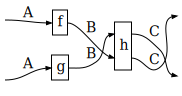

In [60]:
show_diagram(d)

### Compositional Construction

In [101]:
module SandboxMonDiag

using Catlab.WiringDiagrams

import Catlab.Theories: ⋅, ⊗, braid, σ

A,B,C = Ports([:A]), Ports([:B]), Ports([:C])
f = singleton_diagram(Box(:f, A, B))
g = singleton_diagram(Box(:g, A, B))
h = singleton_diagram(Box(:h, B⊗B, C⊗C))

d2 = (f⊗g)⋅σ(B,B)⋅h⋅σ(C,C)

end

Main.SandboxMonDiag

In [102]:
Main.SandboxMonDiag.d2 == d

true

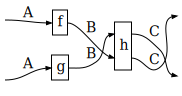

In [103]:
show_diagram(Main.SandboxMonDiag.d2 )

### Expression Construction from Diagram

In [113]:
module SandboxHomExpr

using Catlab.WiringDiagrams
using Catlab.Theories

expr = to_hom_expr(FreeSymmetricMonoidalCategory, Main.SandboxMonDiag.d2)

end

Main.SandboxHomExpr

In [111]:
Main.SandboxHomExpr.expr

compose(otimes(f,g),braid(B,B),h,braid(C,C))

In [239]:
expr_json = JSON.json(Main.SandboxHomExpr.expr)

"{\"args\":[{\"args\":[{\"args\":[\"f\",{\"args\":[\"A\"],\"type_args\":[]},{\"args\":[\"B\"],\"type_args\":[]}],\"type_args\":[{\"args\":[\"A\"],\"type_args\":[]},{\"args\":[\"B\"],\"type_args\":[]}]},{\"args\":[\"g\",{\"args\":[\"A\"],\"type_args\":[]},{\"args\":[\"B\"],\"type_args\":[]}],\"type_args\":[{\"args\":[\"A\"],\"type_args\":[]},{\"args\":[\"B\"],\"type_args\":[]}]}],\"type_args\":[{\"args\":[{\"args\":[\"A\"],\"type_args\":[]},{\"args\":[\"A\"],\"type_args\":[]}],\"type_args\":[]},{\"args\":[{\"args\":[\"B\"],\"type_args\":[]},{\"args\":[\"B\"],\"type_args\":[]}],\"type_args\":[]}]},{\"args\":[{\"args\":[\"B\"],\"type_args\":[]},{\"args\":[\"B\"],\"type_args\":[]}],\"type_args\":[{\"args\":[{\"args\":[\"B\"],\"type_args\":[]},{\"args\":[\"B\"],\"type_args\":[]}],\"type_args\":[]},{\"args\":[{\"args\":[\"B\"],\"type_args\":[]},{\"args\":[\"B\"],\"type_args\":[]}],\"type_args\":[]}]},{\"args\":[\"h\",{\"args\":[{\"args\":[\"B\"],\"type_args\":[]},{\"args\":[\"B\"],\"type_arg

In [240]:
expr_dict = JSON.parse(expr_json)

Dict{String,Any} with 2 entries:
  "args"      => Any[Dict{String,Any}("args"=>Any[Dict{String,Any}("args"=>Any[…
  "type_args" => Any[Dict{String,Any}("args"=>Any[Dict{String,Any}("args"=>Any[…

In [241]:
to_json_sexpr(expr_json)

"{\"args\":[{\"args\":[{\"args\":[\"f\",{\"args\":[\"A\"],\"type_args\":[]},{\"args\":[\"B\"],\"type_args\":[]}],\"type_args\":[{\"args\":[\"A\"],\"type_args\":[]},{\"args\":[\"B\"],\"type_args\":[]}]},{\"args\":[\"g\",{\"args\":[\"A\"],\"type_args\":[]},{\"args\":[\"B\"],\"type_args\":[]}],\"type_args\":[{\"args\":[\"A\"],\"type_args\":[]},{\"args\":[\"B\"],\"type_args\":[]}]}],\"type_args\":[{\"args\":[{\"args\":[\"A\"],\"type_args\":[]},{\"args\":[\"A\"],\"type_args\":[]}],\"type_args\":[]},{\"args\":[{\"args\":[\"B\"],\"type_args\":[]},{\"args\":[\"B\"],\"type_args\":[]}],\"type_args\":[]}]},{\"args\":[{\"args\":[\"B\"],\"type_args\":[]},{\"args\":[\"B\"],\"type_args\":[]}],\"type_args\":[{\"args\":[{\"args\":[\"B\"],\"type_args\":[]},{\"args\":[\"B\"],\"type_args\":[]}],\"type_args\":[]},{\"args\":[{\"args\":[\"B\"],\"type_args\":[]},{\"args\":[\"B\"],\"type_args\":[]}],\"type_args\":[]}]},{\"args\":[\"h\",{\"args\":[{\"args\":[\"B\"],\"type_args\":[]},{\"args\":[\"B\"],\"type_arg

### Diagram Construction from Expression

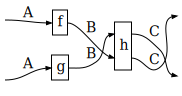

In [116]:
show_diagram(to_wiring_diagram(Main.SandboxHomExpr.expr))

In [ ]:
## Presentations

In [118]:
@present TrigFunctions(FreeCartesianCategory) begin
    R::Ob
    sin::Hom(R,R)
    cos::Hom(R,R)
    (+)::Hom(otimes(R,R),R)
    (*)::Hom(otimes(R,R),R)
end

generator(TrigFunctions, :+)

+

In [123]:
gen(name::Symbol) = generator(TrigFunctions, name)

expr = compose(mcopy(gen(:R)), otimes(gen(:sin), gen(:cos)), gen(:*))

LoadError: MethodError: no method matching otimes(::Catlab.Theories.FreeCartesianCategory.Hom{:generator}, ::Catlab.Theories.FreeCartesianCategory.Hom{:generator})

In [129]:
compile_expr(expr, name=:my_trig_polynomial, args=[:x])

LoadError: UndefVarError: expr not defined

## Programs

In [138]:
parsed = @program TrigFunctions (x::R) begin
    y1, y2 = sin(x), cos(x)
    return y1 * y2
end

WiringDiagram{CartesianCategory}([:R], [:R], 
[ 1 => {inputs},
  2 => {outputs},
  3 => Box(:sin, [:R], [:R]),
  4 => Box(:cos, [:R], [:R]),
  5 => Box(:*, [:R,:R], [:R]) ],
[ Wire((1,1) => (3,1)),
  Wire((1,1) => (4,1)),
  Wire((3,1) => (5,1)),
  Wire((4,1) => (5,2)),
  Wire((5,1) => (2,1)) ])

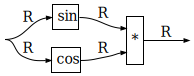

In [140]:
show_diagram(parsed)

In [142]:
parsed2 = @program(TrigFunctions, (x::R) -> sin(x) * cos(x))

WiringDiagram{CartesianCategory}([:R], [:R], 
[ 1 => {inputs},
  2 => {outputs},
  3 => Box(:sin, [:R], [:R]),
  4 => Box(:cos, [:R], [:R]),
  5 => Box(:*, [:R,:R], [:R]) ],
[ Wire((1,1) => (3,1)),
  Wire((1,1) => (4,1)),
  Wire((3,1) => (5,1)),
  Wire((4,1) => (5,2)),
  Wire((5,1) => (2,1)) ])

In [143]:
parsed == parsed2

true

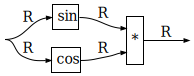

In [144]:
show_diagram(parsed2)

In [242]:
parsed_json = JSON.json(parsed)

"{\"graph\":{\"graph\":{\"ne\":5,\"fadjlist\":[[3,4],[],[5],[5],[2]],\"badjlist\":[[],[5],[1],[1],[3,4]]},\"vprops\":{\"4\":{\"box\":{\"value\":\"cos\",\"input_ports\":[\"R\"],\"output_ports\":[\"R\"]}},\"3\":{\"box\":{\"value\":\"sin\",\"input_ports\":[\"R\"],\"output_ports\":[\"R\"]}},\"5\":{\"box\":{\"value\":\"*\",\"input_ports\":[\"R\",\"R\"],\"output_ports\":[\"R\"]}}},\"eprops\":{\"Edge 4 => 5\":{\"wires\":[{\"value\":null,\"source\":{\"kind\":\"OutputPort\",\"port\":1},\"target\":{\"kind\":\"InputPort\",\"port\":2}}]},\"Edge 1 => 4\":{\"wires\":[{\"value\":null,\"source\":{\"kind\":\"OutputPort\",\"port\":1},\"target\":{\"kind\":\"InputPort\",\"port\":1}}]},\"Edge 1 => 3\":{\"wires\":[{\"value\":null,\"source\":{\"kind\":\"OutputPort\",\"port\":1},\"target\":{\"kind\":\"InputPort\",\"port\":1}}]},\"Edge 3 => 5\":{\"wires\":[{\"value\":null,\"source\":{\"kind\":\"OutputPort\",\"port\":1},\"target\":{\"kind\":\"InputPort\",\"port\":1}}]},\"Edge 5 => 2\":{\"wires\":[{\"value\":nul

In [243]:
parsed_dict = JSON.parse(parsed_json)

Dict{String,Any} with 4 entries:
  "input_ports"  => Any["R"]
  "value"        => nothing
  "output_ports" => Any["R"]
  "graph"        => Dict{String,Any}("vprops"=>Dict{String,Any}("4"=>Dict{Strin…

## Signatures Define Instances

To operate within a theory means to construct (or generate) *instances*.  These theories provide *stub* functions that you must implement in a context-appropriate way.  These stub functions are provided as **workspace templates** that you *clone* to then provide your logic.

### Matrix Category

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats-matrix-category.png)

Instance of `Category` with *(element type, dimension)* pairs as objects and *matrices* as morphisms.

#### As Catlab.jl `@instance`

In [256]:
using LinearAlgebra: I

# Ob Type =
struct MatrixDom
  eltype::Type
  dim::Int
end

# Hom Type = 
# LinearAlgebra.Matrix

@instance Category{MatrixDom, Matrix} begin
  
  # Given a hom, what is its dom?
  dom(M::Matrix) = MatrixDom(eltype(M), size(M,1))

  # Given a hom, what is its codom?
  codom(M::Matrix) = MatrixDom(eltype(M), size(M,2))

  # Given an ob, what is its identity hom?
  id(m::MatrixDom) = Matrix{m.eltype}(I, m.dim, m.dim)

  # Give two compatible homs, what is their composition?
  compose(M::Matrix, N::Matrix) = M*N
end

In [246]:
cat = JSON.json(Category)

LoadError: cannot assign a value to variable Base.cat from module Main

#### As GATs `Instance` instance `yaml`

```yaml
---
instance:
  id: maana-gats-matrix-category
  theory: maana-gats-category-theory
```

#### As a Q `Service` (yaml)

```yaml
---
service:
  id: maana-gats-matrix-category
  name: Matrix Category
  cloneFrom: maana-gats-category-theory
  kinds:
  - name: Elem
  fns:
  - name: munit
    output:
      kind: Elem
  - name: mtimes
    fields:
    - name: x
      kind: Elem
    - name: y
      kind: Elem
    output:
      kind: Elem
  - name: isAssociative
    fields:
    - name: x
      kind: Elem
    - name: y
      kind: Elem
    - name: z
      kind: Elem
    output:
      kind: Boolean
  - name: isLeftUnital
    fields:
    - name: x
      kind: Elem
    output:
      kind: Boolean
  - name: isRightUnital
    fields:
    - name: x
      kind: Elem
    output:
      kind: Boolean
```

#### As Q Workspace

[maana-gats-matrix-category](https://lastknowngood.knowledge.maana.io/workspace/0e215223-1786-4574-80f1-4f64ad313430)

![](https://github.com/maana-io/cat-ml/raw/master/images/maana-q-gats/matrix-category.png)

#### `id`

```javascript
const math = require('mathjs')

const { x: { id, dim, eltype } } = input

const m = math.identity(dim, dim)

return {
  id,
  dom: {
      id,
      eltype,
      dim
  },
  codom: {
      id,
      eltype,
      dim
  },
  data: JSON.stringify(m.toArray())
}
```

#### `compose`

```javascript
  const { f, g } = input

  const M = math.matrix(JSON.parse(f.data))
  const N = math.matrix(JSON.parse(g.data))
  const P = math.multiply(M,N)

  const id = `${f.id} . ${g.id}`
  const eltype = {id: math.getMatrixDataType(P)}

  return {
    id,
    dom: {
      id: `dom(${id})`,
      eltype,
      dim: P.size()[0]
    },
    codom: {
      id: `codom(${id})`,
      eltype,
      dim: P.size()[1]
    },
    data: JSON.stringify(P.toArray())
  }
```

##### Smart CRUD

![](https://github.com/maana-io/cat-ml/raw/master/images/maana-q-gats/matrix-category-smart-crud.png)

##### `createMatrix`

```javascript
const math = require('mathjs')

const { id, data } = input

const json_data = JSON.parse(data)

const m = math.matrix(json_data)

const eltype = math.getMatrixDataType(m)

return {
    id,
    dom: {
        id: `dom(${id})`,
        eltype: { id: eltype },
        dim: m.size()[0]
    },
    codom: {
        id: `codom(${id})`,
        eltype: { id: eltype },
        dim: m.size()[1]
    },
    data
}
```

#### Example Use

In [248]:
M = [0 1;-1 0]

2×2 Array{Int64,2}:
  0  1
 -1  0

```graphql
{
  createMatrix(id:"M",data:"[[0,1],[-1,0]]"){
    id
    dom {
      id
      dim
      eltype { id }
    }
    codom {
      id
      dim
      eltype { id }
    }
    data
  }
}
```

```json
{
  "data": {
    "createMatrix": {
      "id": "M",
      "dom": {
        "id": "dom(M)",
        "dim": 2,
        "eltype": {
          "id": "number"
        }
      },
      "codom": {
        "id": "codom(M)",
        "dim": 2,
        "eltype": {
          "id": "number"
        }
      },
      "data": "[[0,1],[-1,0]]"
    }
  }
}
```

In [249]:
JSON.json(M)

"[[0,-1],[1,0]]"

In [250]:
size(M,1)

2

In [251]:
eltype(M)

Int64

In [253]:
dom(M)

MatrixDom(Int64, 2)

In [257]:
codom(M)

MatrixDom(Int64, 2)

In [35]:
compose(M,M)

2×2 Array{Int64,2}:
 -1   0
  0  -1

```graphql
query compose($M: MatrixAsInput!) {
  compose(f:$M, g:$M) {
    id
    dom {
      id
      dim
      eltype { id }
    }
    codom {
      id
      dim
      eltype { id }
    }
    data    
  }
}
```

```json
{
  "data": {
    "compose": {
      "id": "M . M",
      "dom": {
        "id": "dom(M . M)",
        "dim": 2,
        "eltype": {
          "id": "number"
        }
      },
      "codom": {
        "id": "codom(M . M)",
        "dim": 2,
        "eltype": {
          "id": "number"
        }
      },
      "data": "[[-1,0],[0,-1]]"
    }
  }
}
````

In [36]:
id(dom(M))

2×2 Array{Int64,2}:
 1  0
 0  1

In [48]:
size(M,2)

2

## Extending Theories

### Monoidal Category

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats-monoidal-category.png)


#### Using `Catlab.jl`

In [ ]:
> "Today, we are going to show that a monoid object in the monoidal category of monoids is, in fact, a commutative monoid, which I find rather exciting, really." - Eugenia Cheng

The category of monoids is a monoidal category under cartesian product:

- given a monoid M, then MxM is also a monoid

How is this defined?  [Eckman-Hilton argument](https://en.wikipedia.org/wiki/Eckmann%E2%80%93Hilton_argument) says that two binary operations, ⋅, ⊗, that are both unital, they are the same (and commuitative and associative):
- (a⊗b) ⋅ (c⊗d) = (a⋅c) ⊗ (b⋅d)

In [77]:
@theory MonoidalCategory{Ob,Hom} <: Category{Ob,Hom} begin

    # Morphisms

    # mu: A x A → A
    otimes(A::Ob, B::Ob)::Ob

    # mu: (A ⋅ B) x (C ⋅ D) → ((A ⊗ C) ⋅ (B ⊗ D))
    otimes(f::(A → B), g::(C → D))::((A ⊗ C) → (B ⊗ D))
        ⊣ (A::Ob, B::Ob, C::Ob, D::Ob)

    # eta: 1 → A
    munit()::Ob

    # Aliases
    @op (⊗) := otimes

    # Axioms
    (A ⊗ B) ⊗ C == A ⊗ (B ⊗ C) ⊣ (A::Ob, B::Ob, C::Ob)
    A ⊗ munit() == A ⊣ (A::Ob)
    munit() ⊗ A == A ⊣ (A::Ob)
    (f ⊗ g) ⊗ h == f ⊗ (g ⊗ h) ⊣ (A::Ob, B::Ob, C::Ob, X::Ob, Y::Ob, Z::Ob,
                                f::(A → X), g::(B → Y), h::(C → Z))

    # Functorality axioms.
    ((f ⊗ g) ⋅ (h ⊗ k) == (f ⋅ h) ⊗ (g ⋅ k)
        ⊣ (A::Ob, B::Ob, C::Ob, X::Ob, Y::Ob, Z::Ob,
            f::(A → B), h::(B → C), g::(X → Y), k::(Y → Z)))
    id(A ⊗ B) == id(A) ⊗ id(B) ⊣ (A::Ob, B::Ob)

end

MonoidalCategory

In [75]:
import Catlab.Theories: braid, σ

@syntax FreeSymmetricMonoidalCategory{ObExpr,HomExpr} SymmetricMonoidalCategory begin
  otimes(A::Ob, B::Ob) = associate_unit(new(A,B), munit)
  otimes(f::Hom, g::Hom) = associate(new(f,g))
  compose(f::Hom, g::Hom) = associate(new(f,g; strict=true))
end

Main.FreeSymmetricMonoidalCategory

#### As Q `yaml`

```yaml
---
service:
  maana-gats-monoidal-category:
    cloneFrom: maana-gats-category-theory
    fns:
    - name: otimesOb
      fields:
      - name: A
        kind: Ob
      - name: B
        kind: Ob
      output:
        kind: Ob
    - name: otimesHom
      fields:
      - name: f
        kind: Hom
      - name: g
        kind: Hom
      output:
        kind: Hom
    - name: munit
      output:
        kind: Ob
    - name: isCompositionFunctorial
      fields:
      - name: f
        kind: Hom
      - name: g
        kind: Hom
      - name: h
        kind: Hom
      - name: k
        kind: Hom
      output:
        kind: Boolean
    - name: isIdFunctorial
      fields:
      - name: A
        kind: Ob
      - name: B
        kind: Ob
      output:
        kind: Boolean
```

#### As Q Workspace

[maana-gats-monoidal-category](https://lastknowngood.knowledge.maana.io/workspace/2cc26a46-c27b-42a4-b287-f9ae7f084f98)

![](https://github.com/maana-io/cat-ml/raw/master/images/maana-q-gats/monoidal-category-kg.png)

### Symmetric Monoidal Category

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats-symmetric-monoidal-category.png)


#### Using `Catlab.jl`

In [55]:
module SandboxSMC

using Catlab.GAT
import Catlab.Theories.MonoidalCategory

@theory SymmetricMonoidalCategory{Ob,Hom} <: MonoidalCategory{Ob,Hom} begin
  braid(A::Ob, B::Ob)::((A ⊗ B) → (B ⊗ A))
  @op (σ) := braid

  # Involutivity axiom.
  σ(A,B) ⋅ σ(B,A) == id(A ⊗ B) ⊣ (A::Ob, B::Ob)

  # Coherence axioms.
  σ(A,B⊗C) == (σ(A,B) ⊗ id(C)) ⋅ (id(B) ⊗ σ(A,C)) ⊣ (A::Ob, B::Ob, C::Ob)
  σ(A⊗B,C) == (id(A) ⊗ σ(B,C)) ⋅ (σ(A,C) ⊗ id(B)) ⊣ (A::Ob, B::Ob, C::Ob)

  # Naturality axiom.
  (f ⊗ g) ⋅ σ(B,D) == σ(A,C) ⋅ (g ⊗ f) ⊣ (A::Ob, B::Ob, C::Ob, D::Ob,
                                          f::(A → B), g::(C → D))
end

end

Main.SandboxSMC

#### As Q `yaml`

```yaml
---
service:
  id: maana-gats-symmetric-monoidal-category:
  cloneFrom: maana-gats-monoidal-category
  fns:
  - name: braid
    fields:
    - name: A
      kind: Ob
    - name: B
      kind: Ob
    output:
      kind: Hom
  - name: isInvolutive
    fields:
    - name: A
      kind: Ob
    - name: B
      kind: Ob
    - name: C
      kind: Ob
    output:
      kind: Boolean
  - name: isLeftCoherent
    fields:
    - name: A
      kind: Ob
    - name: B
      kind: Ob
    - name: C
      kind: Ob
    output:
      kind: Boolean
  - name: isRightCoherent
    fields:
    - name: A
      kind: Ob
    - name: B
      kind: Ob
    - name: C
      kind: Ob
    output:
      kind: Boolean
  - name: isNatural
    fields:
    - name: A
      kind: Ob
    - name: B
      kind: Ob
    - name: C
      kind: Ob
    - name: D
      kind: Ob
    - name: f
      kind: Hom
    - name: g
      kind: Hom
    output:
      kind: Boolean
```

#### As Q Workspace

[maana-gats-monoidal-category](https://lastknowngood.knowledge.maana.io/workspace/f5cd68d5-cfbf-4e0c-af20-d3c745b077bf)

![](https://github.com/maana-io/cat-ml/raw/master/images/maana-q-gats/symmetric-monoidal-category-kg.png)

### Monoidal Category with Diagonals

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats-monoidal-category-with-diagonals.png)


#### Using `Catlab.jl`

In [54]:
# Cartesian category
####################

""" Theory of *monoidal categories with diagonals*
A monoidal category with diagonals is a symmetric monoidal category equipped
with coherent operations of copying and deleting, also known as a supply of
commutative comonoids. Unlike in a cartesian category, the naturality axioms
need not be satisfied.
References:
- Fong & Spivak, 2019, "Supplying bells and whistles in symmetric monoidal
  categories" ([arxiv:1908.02633](https://arxiv.org/abs/1908.02633))
- Selinger, 2010, "A survey of graphical languages for monoidal categories",
  Section 6.6: "Cartesian center"
- Selinger, 1999, "Categorical structure of asynchrony"
"""
@theory MonoidalCategoryWithDiagonals{Ob,Hom} <: SymmetricMonoidalCategory{Ob,Hom} begin
  mcopy(A::Ob)::(A → (A ⊗ A))
  @op (Δ) := mcopy
  delete(A::Ob)::(A → munit())
  @op (◊) := delete

  # Commutative comonoid axioms.
  Δ(A) ⋅ (Δ(A) ⊗ id(A)) == Δ(A) ⋅ (id(A) ⊗ Δ(A)) ⊣ (A::Ob)
  Δ(A) ⋅ (◊(A) ⊗ id(A)) == id(A) ⊣ (A::Ob)
  Δ(A) ⋅ (id(A) ⊗ ◊(A)) == id(A) ⊣ (A::Ob)
  Δ(A) ⋅ σ(A,A) == Δ(A) ⊣ (A::Ob)

  # Coherence axioms.
  Δ(A⊗B) == (Δ(A) ⊗ Δ(B)) ⋅ (id(A) ⊗ σ(A,B) ⊗ id(B)) ⊣ (A::Ob, B::Ob)
  ◊(A⊗B) == ◊(A) ⊗ ◊(B) ⊣ (A::Ob, B::Ob)
  Δ(munit()) == id(munit())
  ◊(munit()) == id(munit())
end

LoadError: cannot assign a value to variable Theories.MonoidalCategoryWithDiagonals from module Main

### Cartesian Category

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats-cartesian-category.png)


#### Using `Catlab.jl`

In [ ]:
""" Theory of *cartesian (monoidal) categories*
For the traditional axiomatization of products, see
[`CategoryWithProducts`](@ref).
"""
@theory CartesianCategory{Ob,Hom} <: MonoidalCategoryWithDiagonals{Ob,Hom} begin
  pair(f::(A → B), g::(A → C))::(A → (B ⊗ C)) ⊣ (A::Ob, B::Ob, C::Ob)
  proj1(A::Ob, B::Ob)::((A ⊗ B) → A)
  proj2(A::Ob, B::Ob)::((A ⊗ B) → B)

  # Definitions of pairing and projections.
  pair(f,g) == Δ(C)⋅(f⊗g) ⊣ (A::Ob, B::Ob, C::Ob, f::(C → A), g::(C → B))
  proj1(A,B) == id(A)⊗◊(B) ⊣ (A::Ob, B::Ob)
  proj2(A,B) == ◊(A)⊗id(B) ⊣ (A::Ob, B::Ob)
  
  # Naturality axioms.
  f⋅Δ(B) == Δ(A)⋅(f⊗f) ⊣ (A::Ob, B::Ob, f::(A → B))
  f⋅◊(B) == ◊(A) ⊣ (A::Ob, B::Ob, f::(A → B))
end

### Monoidal Category with Bidiagonals

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats-monoidal-category-with-bidiagonals.png)


#### Using `Catlab.jl`

In [ ]:
# Biproduct category
####################

""" Theory of *monoidal categories with bidiagonals*
The terminology is nonstandard (is there any standard terminology?) but is
supposed to mean a monoidal category with coherent diagonals and codiagonals.
Unlike in a biproduct category, the naturality axioms need not be satisfied.
"""
@signature MonoidalCategoryWithBidiagonals{Ob,Hom} <:
    MonoidalCategoryWithDiagonals{Ob,Hom} begin
  mmerge(A::Ob)::((A ⊗ A) → A)
  @op (∇) := mmerge
  create(A::Ob)::(munit() → A)
  @op (□) := create
end


### Biproduct Category

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats-biproduct-category.png)


#### Using `Catlab.jl`

In [ ]:
""" Theory of *biproduct categories*
Mathematically the same as [`SemiadditiveCategory`](@ref) but written
multiplicatively, instead of additively.
"""
@theory BiproductCategory{Ob,Hom} <: MonoidalCategoryWithBidiagonals{Ob,Hom} begin
  pair(f::(A → B), g::(A → C))::(A → (B ⊗ C)) ⊣ (A::Ob, B::Ob, C::Ob)
  copair(f::(A → C), g::(B → C))::((A ⊗ B) → C) ⊣ (A::Ob, B::Ob, C::Ob)
  proj1(A::Ob, B::Ob)::((A ⊗ B) → A)
  proj2(A::Ob, B::Ob)::((A ⊗ B) → B)
  coproj1(A::Ob, B::Ob)::(A → (A ⊗ B))
  coproj2(A::Ob, B::Ob)::(B → (A ⊗ B))
  
  # Naturality axioms.
  f⋅Δ(B) == Δ(A)⋅(f⊗f) ⊣ (A::Ob, B::Ob, f::(A → B))
  f⋅◊(B) == ◊(A) ⊣ (A::Ob, B::Ob, f::(A → B))
  ∇(A)⋅f == (f⊗f)⋅∇(B) ⊣ (A::Ob, B::Ob, f::(A → B))
  □(A)⋅f == □(B) ⊣ (A::Ob, B::Ob, f::(A → B))
  
  # Bimonoid axioms. (These follow from naturality + coherence axioms.)
  ∇(A)⋅Δ(A) == (Δ(A)⊗Δ(A)) ⋅ (id(A)⊗σ(A,A)⊗id(A)) ⋅ (∇(A)⊗∇(A)) ⊣ (A::Ob)
  ∇(A)⋅◊(A) == ◊(A) ⊗ ◊(A) ⊣ (A::Ob)
  □(A)⋅Δ(A) == □(A) ⊗ □(A) ⊣ (A::Ob)
  □(A)⋅◊(A) == id(munit()) ⊣ (A::Ob)
end

### Closed Monoidal Category

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats-closed-monoidal-category.png)


#### Using `Catlab.jl`

In [ ]:
# Closed monoidal category
##########################

""" Theory of (symmetric) *closed monoidal categories*
"""
@signature ClosedMonoidalCategory{Ob,Hom} <: SymmetricMonoidalCategory{Ob,Hom} begin
  # Internal hom of A and B, an object representing Hom(A,B)
  hom(A::Ob, B::Ob)::Ob

  # Evaluation map
  ev(A::Ob, B::Ob)::((hom(A,B) ⊗ A) → B)

  # Currying (aka, lambda abstraction)
  curry(A::Ob, B::Ob, f::((A ⊗ B) → C))::(A → hom(B,C)) ⊣ (C::Ob)
end

### Markov Category

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats-markov-category.png)


In [ ]:
#### Using `Catlab.jl`

In [ ]:

""" Theory of *Markov categories*
"""
@signature MarkovCategory{Ob,Hom} <: MonoidalCategoryWithDiagonals{Ob,Hom} begin
  expectation(M::(A → B))::(A → B) <= (A::Ob, B::Ob)
  @op (𝔼) := expectation
end

### Cartesian Closed Category

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats-cartesian-closed-category.png)


In [ ]:
#### Using `Catlab.jl`

In [ ]:
# Cartesian closed category
###########################

""" Theory of *cartesian closed categories*, aka CCCs
A CCC is a cartesian category with internal homs (aka, exponential objects).
FIXME: This theory should also extend `ClosedMonoidalCategory`, but multiple
inheritance is not yet supported.
"""
@signature CartesianClosedCategory{Ob,Hom} <: CartesianCategory{Ob,Hom} begin
  hom(A::Ob, B::Ob)::Ob
  ev(A::Ob, B::Ob)::((hom(A,B) ⊗ A) → B)
  curry(A::Ob, B::Ob, f::((A ⊗ B) → C))::(A → hom(B,C)) ⊣ (C::Ob)
end

### Compact Closed Category

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats-compact-closed-category.png)


#### Using `Catlab.jl`

In [ ]:
# Compact closed category
#########################

""" Theory of *compact closed categories*
"""
@theory CompactClosedCategory{Ob,Hom} <: ClosedMonoidalCategory{Ob,Hom} begin
  # Dual A^* of object A
  dual(A::Ob)::Ob

  # Unit of duality, aka the coevaluation map
  dunit(A::Ob)::(munit() → (dual(A) ⊗ A))

  # Counit of duality, aka the evaluation map
  dcounit(A::Ob)::((A ⊗ dual(A)) → munit())

  # Adjoint mate of morphism f.
  mate(f::(A → B))::(dual(B) → dual(A)) ⊣ (A::Ob, B::Ob)
  
  # Axioms for closed monoidal structure.
  hom(A, B) == B ⊗ dual(A) ⊣ (A::Ob, B::Ob)
  ev(A, B) == id(B) ⊗ (σ(dual(A), A) ⋅ dcounit(A)) ⊣ (A::Ob, B::Ob)
  (curry(A, B, f) == (id(A) ⊗ (dunit(B) ⋅ σ(dual(B), B))) ⋅ (f ⊗ id(dual(B)))
   ⊣ (A::Ob, B::Ob, C::Ob, f::((A ⊗ B) → C)))
end

### Dagger Category

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats-dagger-category.png)


#### Using `Catlab.jl`

In [ ]:
# Dagger category
#################

""" Theory of *dagger categories*
"""
@signature DaggerCategory{Ob,Hom} <: Category{Ob,Hom} begin
  dagger(f::(A → B))::(B → A) ⊣ (A::Ob, B::Ob)
end


### Dagger Symmetric Monoidal Category

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats-dagger-symmetric-monoidal-category.png)


#### Using `Catlab.jl`

In [ ]:
"" Theory of *dagger symmetric monoidal categories*
Also known as a [symmetric monoidal dagger
category](https://ncatlab.org/nlab/show/symmetric+monoidal+dagger-category).
FIXME: This theory should also extend `DaggerCategory`, but multiple inheritance
is not yet supported.
"""
@signature DaggerSymmetricMonoidalCategory{Ob,Hom} <: SymmetricMonoidalCategory{Ob,Hom} begin
  dagger(f::(A → B))::(B → A) ⊣ (A::Ob, B::Ob)
end


### Dagger Compact Category

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats-dagger-compact-category.png)


#### Using `Catlab.jl`

In [ ]:
""" Theory of *dagger compact categories*
In a dagger compact category, there are two kinds of adjoints of a morphism
`f::Hom(A,B)`, the adjoint mate `mate(f)::Hom(dual(B),dual(A))` and the dagger
adjoint `dagger(f)::Hom(B,A)`. In the category of Hilbert spaces, these are
respectively the Banach space adjoint and the Hilbert space adjoint (Reed-Simon,
Vol I, Sec VI.2). In Julia, they would correspond to `transpose` and `adjoint`
in the official `LinearAlegbra` module. For the general relationship between
mates and daggers, see Selinger's survey of graphical languages for monoidal
categories.
FIXME: This theory should also extend `DaggerCategory`, but multiple inheritance
is not yet supported.
"""
@signature DaggerCompactCategory{Ob,Hom} <: CompactClosedCategory{Ob,Hom} begin
  dagger(f::(A → B))::(B → A) ⊣ (A::Ob, B::Ob)
end

### Traced Monoidal Category

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats-traced-monoidal-category.png)

#### Using `Catlab.jl`

In [ ]:
# Traced monoidal category
##########################

""" Theory of *traced monoidal categories*
"""
@signature TracedMonoidalCategory{Ob,Hom} <: SymmetricMonoidalCategory{Ob,Hom} begin
  trace(X::Ob, A::Ob, B::Ob, f::((X ⊗ A) → (X ⊗ B)))::(A → B)
end


### Hypergraph Category

![](https://github.com/maana-io/cat-ml/raw/master/thumbnails/maana-gats-hypergraph-category.png)


#### Using `Catlab.jl`

In [ ]:
# Hypergraph category
#####################

""" Theory of *hypergraph categories*
Hypergraph categories are also known as "well-supported compact closed
categories" and "spidered/dungeon categories", among other things.
FIXME: Should also inherit `ClosedMonoidalCategory` and `DaggerCategory`, but
multiple inheritance is not yet supported.
"""
@theory HypergraphCategory{Ob,Hom} <: MonoidalCategoryWithBidiagonals{Ob,Hom} begin
  # Self-dual compact closed category.
  dunit(A::Ob)::(munit() → (A ⊗ A))
  dcounit(A::Ob)::((A ⊗ A) → munit())
  dagger(f::(A → B))::(B → A) ⊣ (A::Ob, B::Ob)

  dunit(A) == create(A) ⋅ mcopy(A) ⊣ (A::Ob)
  dcounit(A) == mmerge(A) ⋅ delete(A) ⊣ (A::Ob)
  (dagger(f) == (id(Y) ⊗ dunit(X)) ⋅ (id(Y) ⊗ f ⊗ id(X)) ⋅ (dcounit(Y) ⊗ id(X))
   ⊣ (A::Ob, B::Ob, f::(A → B)))
end